In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path='tflite_models/M-LSD_512_large_fp32.tflite')

interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [2]:
img = cv2.imread( "../../deep_sort/demo/frames/40.png")
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [3]:
from utils import pred_lines, pred_squares

r = dict( input_shape = [512,512],
    score_thr = 0.3,
    dist_thr = 30 )

lines = pred_lines(rgb, interpreter, input_details, output_details, **r)
#lines
# new_segments, squares, score_array, inter_points = pred_squares(rgb, interpreter, input_details, output_details)

In [4]:
from sympy import Point, Line
from sympy.geometry import Segment
  
linesSet = set()
for line in lines:
    pt1, pt2 = line[:2], line[2:]
    l = Line(pt1, pt2)
    # print( float(l.length) )
    linesSet.add( l )
len(linesSet)

44

In [36]:
import itertools
from collections import defaultdict

T = np.array([[0, -1], [1, 0]])
def line_intersect(a1, a2, b1, b2):
    # print( a1.shape )
    da = np.atleast_2d(a2 - a1)
    # print( da.shape )
    db = np.atleast_2d(b2 - b1)
    dp = np.atleast_2d(a1 - b1)
    dap = np.dot(da, T)
    denom = np.sum(dap * db, axis=1)
    num = np.sum(dap * dp, axis=1)
    return np.atleast_2d(num / denom).T * db + b1
# r = np.array( list(itertools.combinations( lines,2 )))
# print( r[1])
# r=r.reshape(-1,8)
# print( r[1])
# line_intersect( r[:,:2],r[:,2:4],r[:,4:6],r[:,6:])


In [37]:
def is_at_side(pt, a):
    return (pt.x - a.p1.x)*(pt.x - a.p2.x) >=0 and (pt.y - a.p1.y)*(pt.y - a.p2.y)

def dbg_dump_pt(pt):
    print( pt.n())

去除相似的线，计算各个线的交点坐标

快速算法
主要的消耗是defaultdict 和object hash，所以...

In [49]:
r = np.array( list(itertools.combinations( lines,2 )))
# print( r[1])
r=r.reshape(-1,8)
# print( r[1])
rs = line_intersect( r[:,:2],r[:,2:4],r[:,4:6],r[:,6:])

intersects = defaultdict(set)
for xy, ls in zip(rs,r):
    p = (xy[0],xy[1])
    intersects[ p ].add( tuple(ls[:4]) )
    intersects[ p ].add( tuple(ls[4:]) )

In [51]:

# 删除相似的线
for a,b in itertools.combinations( linesSet,2 ):
    # 下面的比较精度偏低，但不太影响
    if (a.distance(b.p1)<5 and a.distance(b.p2)<5): # or (b.distance(a.p1)<5 and b.distance(a.p2)<5):
        # print( 'similar line discard' )
        linesSet.discard(b)


# 计算交点
intersects = defaultdict(set)
for a,b in itertools.combinations( linesSet,2 ):
    if a == b or a.is_parallel(b): 
        continue
    pts = a.intersection(b)
    if pts: # and abs(pts[0].x)<10000 and abs(pts[0].y)<10000:         # if two far away , treat as parallel
        pt = pts[0]
        # 如果点在线的一侧，可以保留
        if is_at_side(pt,a) and is_at_side(pt,b):
            intersects[ pt ].add( a )
            intersects[ pt ].add( b )       

len(intersects)

298

1. 如果两个点距离非常近，应该合并
2. 合并后的box，应该取并集
3. 

In [52]:
MAX_DISTANCE = 30
# 先排序
pts_s = sorted( intersects.keys(), key=lambda p: p.x )
# 搜索相邻的点，合并关联的Line
for i in range(0, len(pts_s)-1):
    pt1 = pts_s[i]
    if len(intersects[pt1]) == 0: continue
    for j in range( i+1, len(pts_s)):
        pt2 = pts_s[j]
        if len(intersects[pt2])==0 or pt1.x+MAX_DISTANCE<pt2.x: break

        if pt1.distance(pt2) < MAX_DISTANCE:
            intersects[pt1] = intersects[pt1].union( intersects[pt2] )
            intersects[pt2].clear()  # 清空

# 按照关联Line的数量排序
remaining_pts = list(filter( lambda s: len(s[1])>0, intersects.items() ))
remaining_pts = sorted( remaining_pts, key=lambda x: len(x[1]), reverse=True )
# for pt,sublines in remaining_pts[:10]:
#     print( float(pt.x), float(pt.y), len(sublines))

pt= 37 275
pt= 81 280
pt= 6 272
pt= 2782 307
pt= 70 615


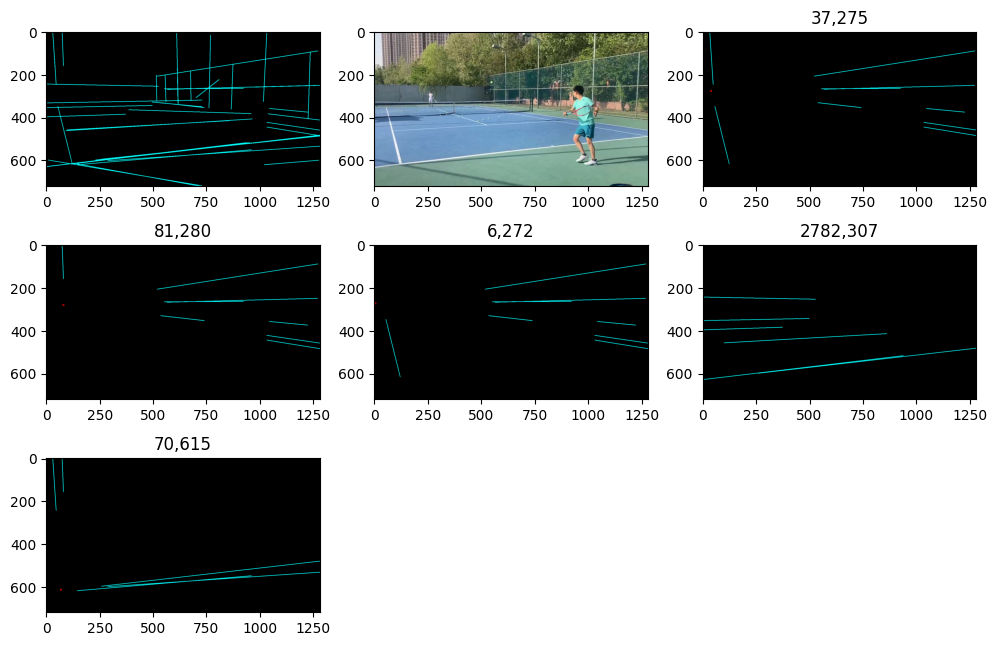

In [53]:
fig,axe=plt.subplots(figsize=(12,8),dpi=100)

img_output = np.zeros_like( img )

# draw lines
for line in lines:
    x_start, y_start, x_end, y_end = [int(val) for val in line]
    cv2.line(img_output, (x_start, y_start), (x_end, y_end), [0,255,255], 2)
plt.subplot(3,3,1)
plt.imshow( img_output )
plt.subplot(3,3,2)
plt.imshow( rgb )

for i in range(5):
    (x,y), sublines = remaining_pts[i]
    print( 'pt=',int(x),int(y))
    img_output = np.zeros_like( img )
    for l in sublines:
        cv2.line(img_output, (int(l.p1.x), int(l.p1.y)), (int(l.p2.x),int(l.p2.y)), [0,255,255], 2)

        ll = Line( l.p1.n(8), l.p2.n(8))
        # print( 'line:', ll.slope, ll.coefficients[2]/ll.coefficients[1] )
        # print( ll ,',')
    # print( x,y )
    cv2.circle( img_output, (int(x),int(y)), 3, [255,0,0],2 )
    cv2.imwrite("tmp/%d.png" % i , img_output )
    plt.subplot(3,3,3+i)
    plt.imshow( img_output )
    plt.title( '%d,%d' % (x,y))